In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [28]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [25]:
dataset_path = '/content/drive/MyDrive/105_classes_pins_dataset/6_classes_pins_dataset'

In [26]:
# Get class names
class_names = os.listdir(dataset_dir)
class_names = [c for c in class_names if os.path.isdir(os.path.join(dataset_dir, c))]
num_classes = len(class_names)

# Print number of classes
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [4]:
# Parameters
img_size = 224  # Input size for DenseNet
batch_size = 32
num_classes = 6  # Adjust based on your dataset

In [5]:
# Data Augmentation and Generators
datagen = ImageDataGenerator(
    rescale=1.0/255,           # Normalize pixel values
    validation_split=0.2,      # Use 20% for validation
    rotation_range=20,         # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
# Training Data Generator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 647 images belonging to 6 classes.


In [32]:
# Validation Data Generator
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 159 images belonging to 6 classes.


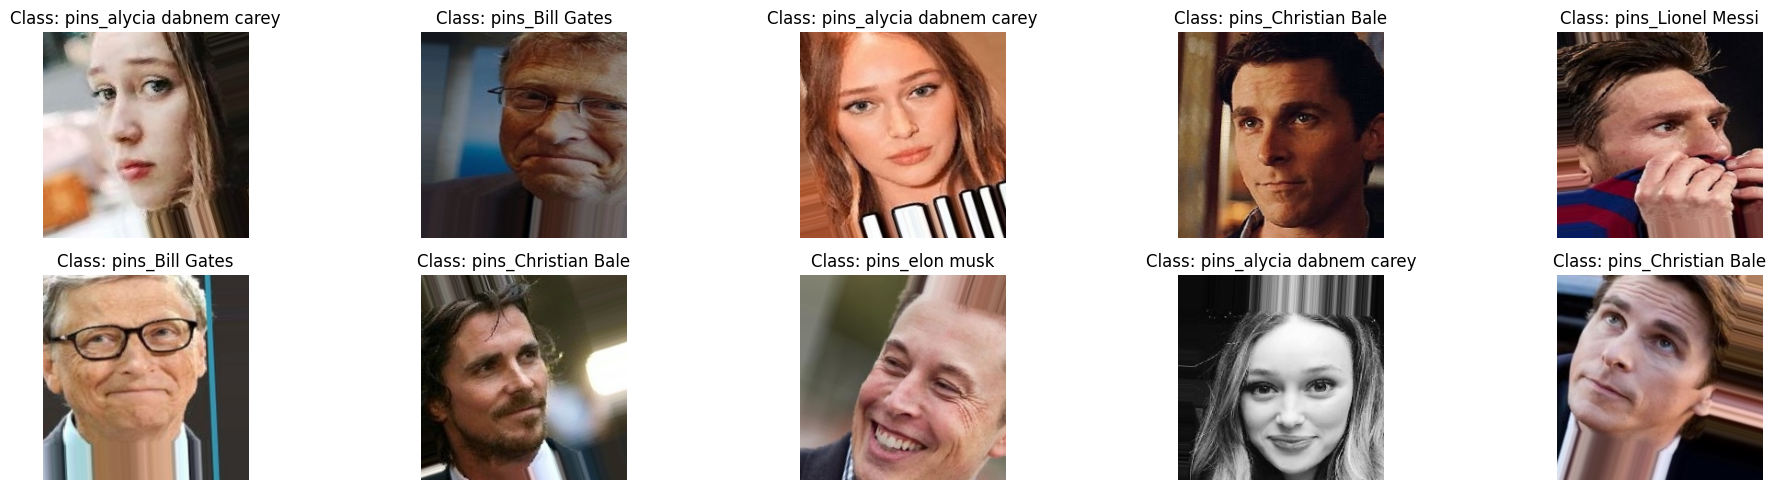

In [34]:
class_labels = list(train_generator.class_indices.keys())

# Reset the generator to start from the first batch
train_generator.reset()

# Fetch one batch of images and labels
images, labels = next(train_generator)

# Convert one-hot encoded labels to class indices
label_indices = np.argmax(labels, axis=1)

# Plot the first 10 images
plt.figure(figsize=(20, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(images[i])  # Display the image
    plt.title(f"Class: {class_labels[label_indices[i]]}")  # Show the class label
    plt.axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [12]:
# Load DenseNet model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Freeze the base model layers
base_model.trainable = False

In [14]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [15]:
# Final model
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # Adjust based on your needs
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 267s 10s/step - accuracy: 0.2352 - loss: 2.5689 - val_accuracy: 0.4375 - val_loss: 1.3780
Epoch 2/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 2:24 8s/step - accuracy: 0.2812 - loss: 1.8649

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 279ms/step - accuracy: 0.2812 - loss: 1.8649 - val_accuracy: 0.4839 - val_loss: 1.2178
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.4410 - loss: 1.5772 - val_accuracy: 0.6016 - val_loss: 1.2242
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - accuracy: 0.5000 - loss: 1.4399 - val_accuracy: 0.6774 - val_loss: 1.1814
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 155s 8s/step - accuracy: 0.4377 - loss: 1.4571 - val_accuracy: 0.6094 - val_loss: 1.1611
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 728ms/step - accuracy: 0.2857 - loss: 1.7695 - val_accuracy: 0.6774 - val_loss: 1.0977
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 150s 7s/step - accuracy: 0.4840 - loss: 1.3654 - val_accuracy: 0.6719 - val_loss: 1.0773
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - accuracy: 0.4688 - loss: 1.3504 - val_accuracy: 0.6129 - val_loss: 1.1914
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.4736 - loss: 1.3087 - val_accuracy: 0.6172 - val_

In [20]:


# Predict on validation data
val_generator.reset()
y_pred_probs = model.predict(val_generator, batch_size=batch_size)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision
precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

# Recall
recall = recall_score(y_true, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

# F1-Score
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1-Score: {f1:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step
Accuracy: 0.19
Precision: 0.18
Recall: 0.16
F1-Score: 0.16


In [21]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


Classification Report:
                           precision    recall  f1-score   support

         pins_Bill Gates       0.09      0.17      0.11        24
     pins_Christian Bale       0.26      0.17      0.20        30
  pins_Cristiano Ronaldo       0.29      0.11      0.15        19
       pins_Lionel Messi       0.00      0.00      0.00        17
pins_alycia dabnem carey       0.30      0.33      0.32        42
          pins_elon musk       0.15      0.19      0.16        27

                accuracy                           0.19       159
               macro avg       0.18      0.16      0.16       159
            weighted avg       0.20      0.19      0.19       159



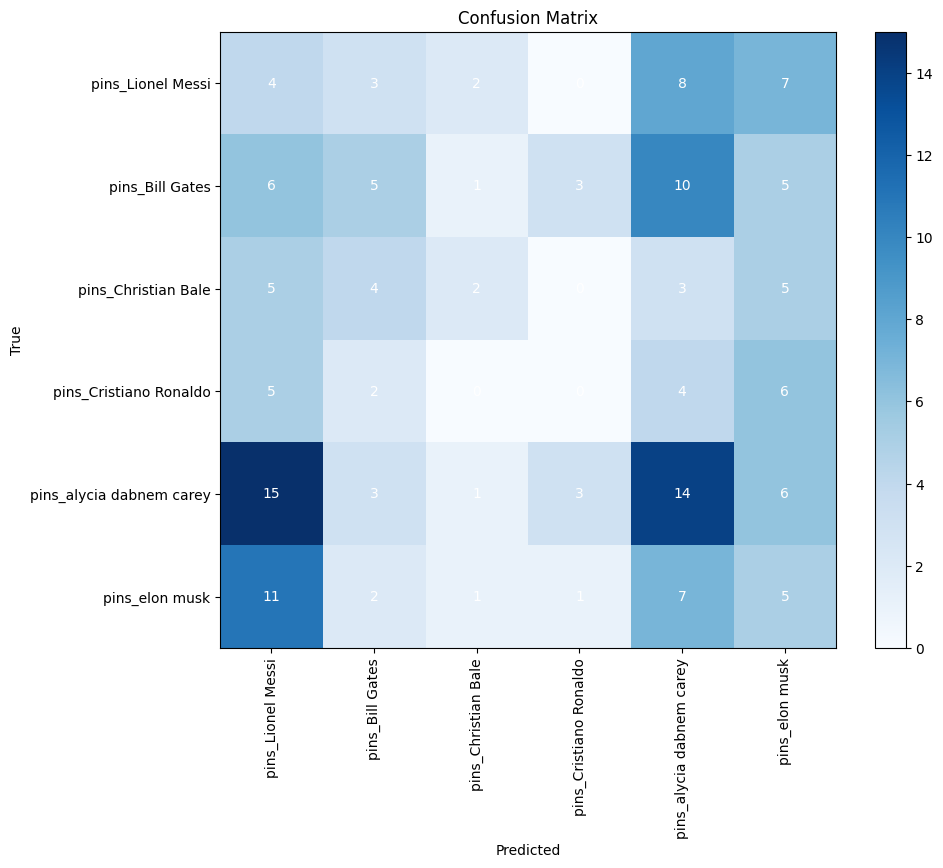

In [27]:


# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a figure for the confusion matrix
plt.figure(figsize=(10, 8))

# Plot the confusion matrix with a color map
plt.imshow(cm, cmap='Blues')

# Title and labels
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(num_classes), class_names, rotation=90)
plt.yticks(np.arange(num_classes), class_names)

# Annotate each cell with the numeric value
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='white')

# Show the plot
plt.show()


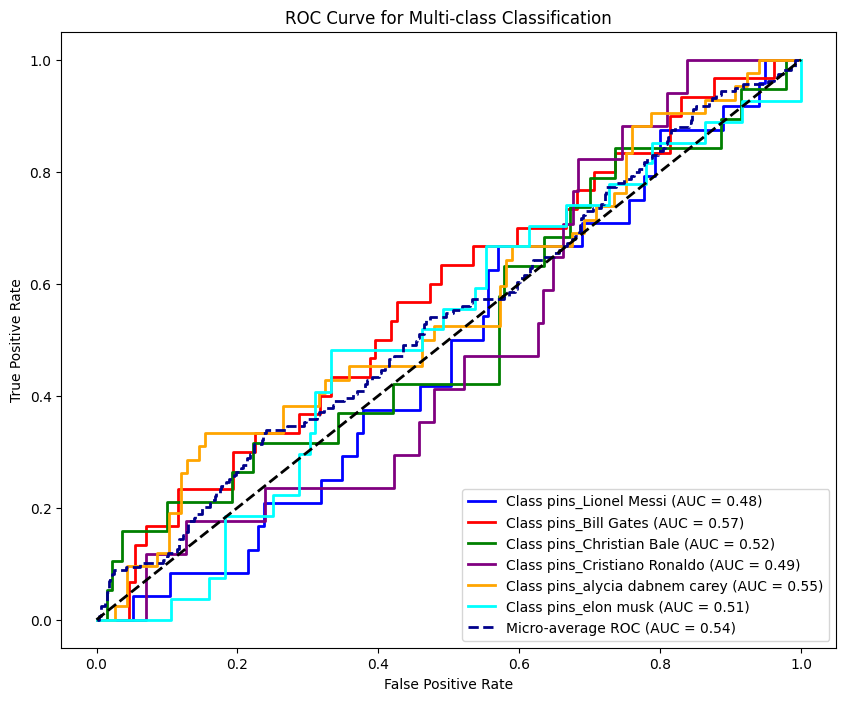

In [29]:

# Ensure y_true is label-binarized for multi-class ROC/AUC
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))  # Convert to one-hot
n_classes = y_true_bin.shape[1]  # Number of classes

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area (useful for overall metrics)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan'])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )

# Plot the micro-average ROC curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    color='darkblue',
    linestyle='--',
    lw=2,
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})"
)

# Add diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot
plt.title("ROC Curve for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


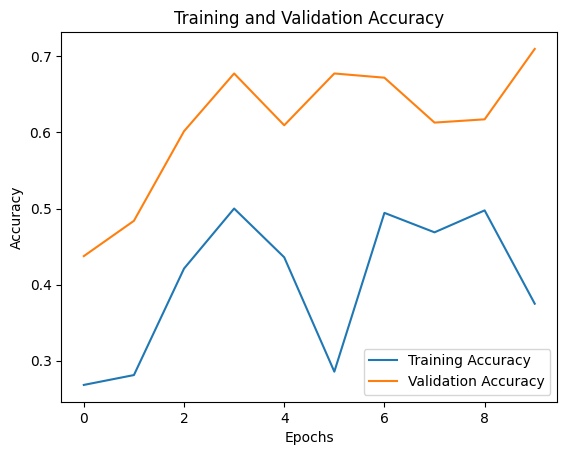

In [30]:
# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

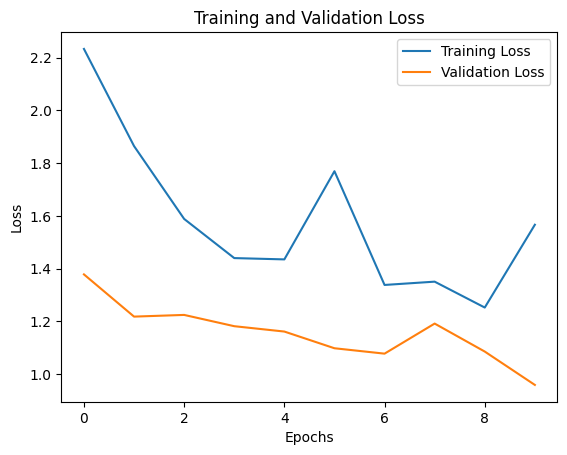

In [31]:
# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()